In [6]:
import os
from nipype.interfaces import fsl
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model
from config import root
from IPython.display import Image

fsl.FSLCommand.set_default_output_type("NIFTI_GZ")

In [7]:
def make_contrasts(contrasts, names, con_type="T", show_output=True):
    """Make contrasts as read into FSL"""

    contrasts_fmt = []
    for contrast in contrasts:

        # create contrast title
        title_left, title_right = [], []
        for k, v in contrast.items():
            title_left += [k] if v > 0 else []
            title_right += [k] if v < 0 else []
        title = ", ".join(title_left) + " > " + ", ".join(title_right)

        weights_per_regr = []
        for name in names:
            weight = contrast[name] if name in contrast.keys() else 0
            weights_per_regr.append(weight)

        contrasts_fmt.append((title, con_type, names, weights_per_regr))

    if show_output:
        for con in contrasts_fmt:
            print("="*20)
            print(con[0])
            print("-"*20)
            print(con[1])
            for reg, weight in zip(con[2], con[3]):
                print(reg, "\t", weight)
            print("="*20)
            print("\n")

    return contrasts_fmt

def pop_decay(in_file="", duration=.2, **kwargs):

    from nipype.interfaces.base import Bunch
    import pandas as pd

    # the data
    regs = pd.read_csv(in_file, header=0)
    conditions = regs.columns.tolist()
    conditions.remove("onset")
    onsets = [regs.onset] * len(conditions)
    durations = [ [duration] * len(regs) ] * len(conditions)
    amplitudes = regs[conditions].values.T.tolist()
    
    output = Bunch(conditions=conditions, onsets=onsets,
                   durations=durations, amplitudes=amplitudes)

    return output

# Prepare

In [8]:
# pathnames
base_dir = os.path.join(root, "data")
output_dir = os.path.join(root, "data", "output")
working_dir = os.path.join(root, "data", "working_dir")

# MNI standard file
standard = os.path.join(root, "data", "in_analysis", "nii", "standard")
mni_standard_path = os.path.join(standard, "MNI152_T1_1mm_brain.nii.gz")
mni_brain_standard_path = os.path.join(standard, "MNI152_T1_2mm_brain.nii.gz")

In [9]:
# Params
glm_prefix = "pop_decay_"
TR = 2.1
filter_cutoff = 60

# Lists
sub_list = ["sub_%03d" % i for i in range(1, 7)]

## Input and output nodes

In [10]:
# iterate over subjects
infosource = pe.Node(
    util.IdentityInterface(
        fields=["sub_id"]),
    name="infosource")

# Define iterable attributes
infosource.iterables = [("sub_id", sub_list)]

# File templates for different subjects and sessions
templates = {
    "runs"     : "output/highpass/ses_*{sub_id}/_hp_filter*/run_*_st_mcf_warp_bet_smooth_hpf.nii.gz",
    "behavior" : "search/regs/{sub_id}_ses_*_scn_*.txt"
}

# SelectFiles Node to handle session specific file templates
files = pe.Node(
    SelectFiles(
        templates,
        base_directory=base_dir,
        sort_filelist=True),
    name="files")

# Create datasink to store important
# files in useful, more accessable locations.
datasink = pe.Node(
    DataSink(
        base_directory=base_dir,
        container="output"),
    name="datasink")

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [("_sub_id_", "")]

## Make contrasts

In [13]:
contrasts = [{
    'loc1': 1,
    'loc2': -0.3333333333333333,
    'loc3': -0.3333333333333333,
    'loc4': -0.3333333333333333
}, {
    'loc2': 1,
    'loc1': -0.3333333333333333,
    'loc3': -0.3333333333333333,
    'loc4': -0.3333333333333333
}, {
    'loc3': 1,
    'loc1': -0.3333333333333333,
    'loc2': -0.3333333333333333,
    'loc4': -0.3333333333333333
}, {
    'loc4': 1,
    'loc1': -0.3333333333333333,
    'loc2': -0.3333333333333333,
    'loc3': -0.3333333333333333
}, {
    'loc_lag1': 0.5, 
    'loc_lag2': 0.5,
}, {
    'loc_lag1': 1.0
}, {
    'loc_lag2': 1.0,
}, {
    'clr_lag1': 0.5, 
    'clr_lag2': 0.5,
}, {
    'clr_lag1': 1.0
}, {
    'clr_lag2': 1.0
}, {
    'loc1': 0.25, 
    'loc2': 0.25, 
    'loc3': 0.25, 
    'loc4': 0.25
}]

conditions = ["loc1", "loc2", "loc3", "loc4",
              "loc_lag1", "loc_lag2",
              "clr_lag1", "clr_lag2"]

# Create contrasts for FSL
contrasts_large = make_contrasts(contrasts, conditions, show_output=False)

## Setup GLM

In [7]:
glm_function = pe.MapNode(
    util.Function(
        input_names=["in_file"],
        output_names=["subject_info"],
        function=pop_decay),
    iterfield=["in_file"],
    name=glm_prefix+"glm_function")

# Specify model
specifymodel = pe.Node(
    model.SpecifyModel(
        high_pass_filter_cutoff=filter_cutoff,
        time_repetition=TR,
        input_units="secs",
    ), 
    name=glm_prefix+"specifymodel"
)

# Level 1 design
level1design = pe.Node(
    fsl.Level1Design(
        bases={"dgamma" : {"derivs": True}},
        interscan_interval=TR,
        model_serial_correlations=True, # Prewhitening
        contrasts=contrasts_large,
    ), 
    name=glm_prefix+"level1design"
)

# model
featmodel = pe.MapNode(
    interface=fsl.FEATModel(),
    name=glm_prefix+"featmodel_ses1",
    iterfield=["fsf_file", "ev_files"]
)

# FILMGLS
filmgls = pe.MapNode(
    interface=fsl.FILMGLS(
        threshold=10
    ),
    iterfield=["design_file", "in_file", "tcon_file"],
    name=glm_prefix+"filmgls"
)

180528-00:38:42,410 workflow INFO:
	 Generated workflow graph: /data/host/Projects/HI/00_PhD/Studies/pop-decay/notebooks/graph_hierarchical.png (graph2use=exec, simple_form=True).


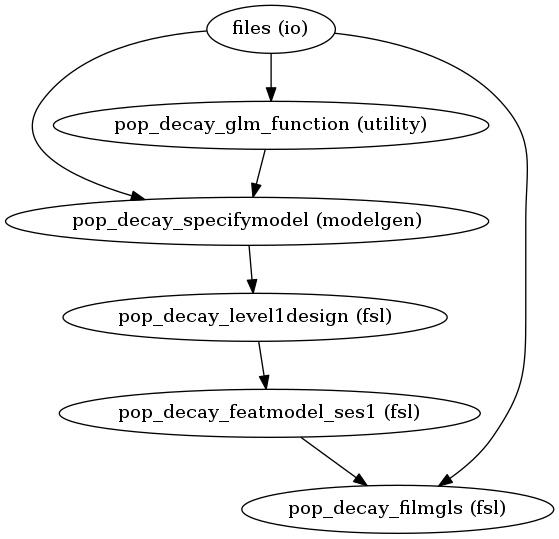

In [8]:
firstlevel = pe.Workflow(name=glm_prefix+"firstlevel", base_dir=working_dir)
firstlevel.connect(infosource, "sub_id", files, "sub_id")
firstlevel.connect(files, "behavior", glm_function, "in_file")
firstlevel.connect(files, "runs", specifymodel, "functional_runs")
firstlevel.connect(files, "runs", filmgls, "in_file")
firstlevel.connect(glm_function, "subject_info", specifymodel, "subject_info")
firstlevel.connect(specifymodel, "session_info", level1design, "session_info")
firstlevel.connect(level1design, "fsf_files", featmodel, "fsf_file")
firstlevel.connect(level1design, "ev_files", featmodel, "ev_files")
firstlevel.connect(featmodel, "design_file", filmgls, "design_file")
firstlevel.connect(featmodel, "con_file", filmgls, "tcon_file")

firstlevel.write_graph(simple_form=True, graph2use="exec", dotfilename="./graph_hierarchical.dot")

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

## Second level

In [9]:
num_contrasts = len(contrasts)
con_list = [str(i+1) for i in range(num_contrasts)]

In [10]:
# iterate over subjects
infosource = pe.Node(
    util.IdentityInterface(fields=["sub_id", "con_num"]),
    name="infosource")

# Define iterable attributes
infosource.iterables = [("sub_id", sub_list),
                        ("con_num", con_list)]

# File templates for different subjects
# SelectFiles Node to handle session specific file templates
cope_path = os.path.join("output", glm_prefix+"filmgls", "{sub_id}", "_"+glm_prefix+"filmgls*", "cope{con_num}.nii.gz")
varcope_path = os.path.join("output", glm_prefix+"filmgls", "{sub_id}", "_"+glm_prefix+"filmgls*", "varcope{con_num}.nii.gz")
warp_field = os.path.join("output", "register_to_standard", "{sub_id}", "orig_field.nii.gz")
premat = os.path.join("output",  "register_to_standard", "{sub_id}", "inplane_bbreg_{sub_id}.dat")
func_path = os.path.join("output", "applywarp", "ses_000{sub_id}", "_applywarp0", "run_000_st_mcf_warp.nii.gz")

templates = {
    "copes"      : cope_path, 
    "varcopes"   : varcope_path, 
    "func"       : func_path,
    "warp_field" : warp_field, 
    "premat"     : premat
}

files = pe.Node(
    SelectFiles(
        templates,
        base_directory=base_dir,
        sort_filelist=True),
    name="files")

# Create datasink to store important
# files in useful, more accessable locations.
datasink = pe.Node(
    DataSink(
        base_directory=base_dir,
        container="output"),
    name="datasink")

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [("_sub_id_", ""),
                                 ("_con_num_", "")]

In [11]:
meanfunc = pe.Node(
    interface=fsl.ImageMaths(
        op_string="-Tmean",
        suffix="_mean"),
    name="meanfunc")

meanfuncmask = pe.Node(
    interface=fsl.BET(
        mask=True,
        no_output=True,
        frac=0.05),
    name="meanfuncmask")

dilatemask = pe.Node(
    interface=fsl.ImageMaths(
        suffix="_dil",
        op_string="-dilF"),
    name="dilatemask")

# Concatenate copes before feeding to Flameo
merge_copes = pe.MapNode(
    interface=fsl.Merge(
        dimension="t"),
    iterfield=["in_files"],
    name="merge_copes")

merge_varcopes = pe.MapNode(
    interface=fsl.Merge(
        dimension="t"),
    iterfield=["in_files"],
    name="merge_varcopes")

# Create a level2 model
l2model_fixed = pe.Node(
    interface=fsl.L2Model(), 
    name="l2model_fixed")

# A fixed effects FLAMEO node, with copes and varcopes as inputs.
fixed_flameo = pe.MapNode(
    interface=fsl.FLAMEO(
        run_mode="fe"),
    iterfield=["cope_file", "var_cope_file"],
    name="fixed_flameo")

In [12]:
applywarp_copes = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_brain_standard_path),
    iterfield=["in_file"],
    name="applywarp_copes")

applywarp_varcopes = pe.MapNode(
    fsl.ApplyWarp(
        ref_file=mni_brain_standard_path),
    iterfield=["in_file"],
    name="applywarp_varcopes")

180528-00:38:44,746 workflow INFO:
	 Generated workflow graph: /data/host/Projects/HI/00_PhD/Studies/pop-decay/notebooks/graph_hierarchical.png (graph2use=exec, simple_form=True).


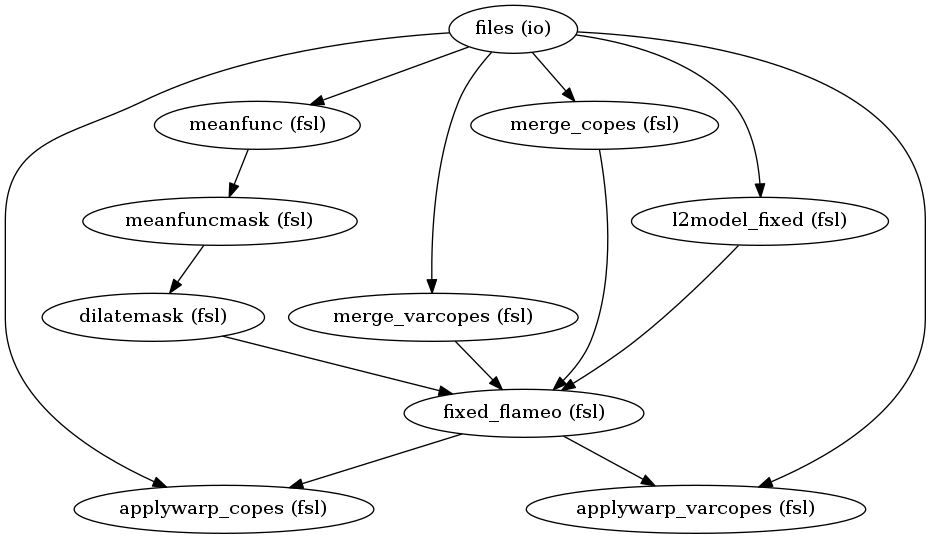

In [13]:
fixed_fx = pe.Workflow(name=glm_prefix+"fixed_fx", base_dir=working_dir)

def num_copes(files):
    return len(files)

fixed_fx.connect(infosource, "sub_id", files, "sub_id")
fixed_fx.connect(infosource, "con_num", files, "con_num")
fixed_fx.connect(files, "func", meanfunc, "in_file")
fixed_fx.connect(meanfunc, "out_file", meanfuncmask, "in_file")
fixed_fx.connect(meanfuncmask, "mask_file", dilatemask, "in_file")
fixed_fx.connect(files, "copes", merge_copes, "in_files")
fixed_fx.connect(files, "varcopes", merge_varcopes, "in_files")
fixed_fx.connect(files, ("copes", num_copes), l2model_fixed, "num_copes")
fixed_fx.connect(dilatemask, "out_file", fixed_flameo, "mask_file")
fixed_fx.connect(merge_copes, "merged_file", fixed_flameo, "cope_file")
fixed_fx.connect(merge_varcopes, "merged_file", fixed_flameo, "var_cope_file")
fixed_fx.connect(l2model_fixed, "design_mat", fixed_flameo, "design_file")
fixed_fx.connect(l2model_fixed, "design_con", fixed_flameo, "t_con_file")
fixed_fx.connect(l2model_fixed, "design_grp", fixed_flameo, "cov_split_file")
fixed_fx.connect(fixed_flameo, "copes", applywarp_copes, "in_file")
fixed_fx.connect(files, "premat", applywarp_copes, "premat")
fixed_fx.connect(files, "warp_field", applywarp_copes, "field_file")
fixed_fx.connect(fixed_flameo, "var_copes", applywarp_varcopes, "in_file")
fixed_fx.connect(files, "premat", applywarp_varcopes, "premat")
fixed_fx.connect(files, "warp_field", applywarp_varcopes, "field_file")

fixed_fx.write_graph(simple_form=True, graph2use="exec", dotfilename="./graph_hierarchical.dot")
Image(width=768, filename="graph_hierarchical.png")

180528-00:38:53,232 workflow INFO:
	 Generated workflow graph: /data/host/Projects/HI/00_PhD/Studies/pop-decay/notebooks/graph_hierarchical.png (graph2use=exec, simple_form=True).


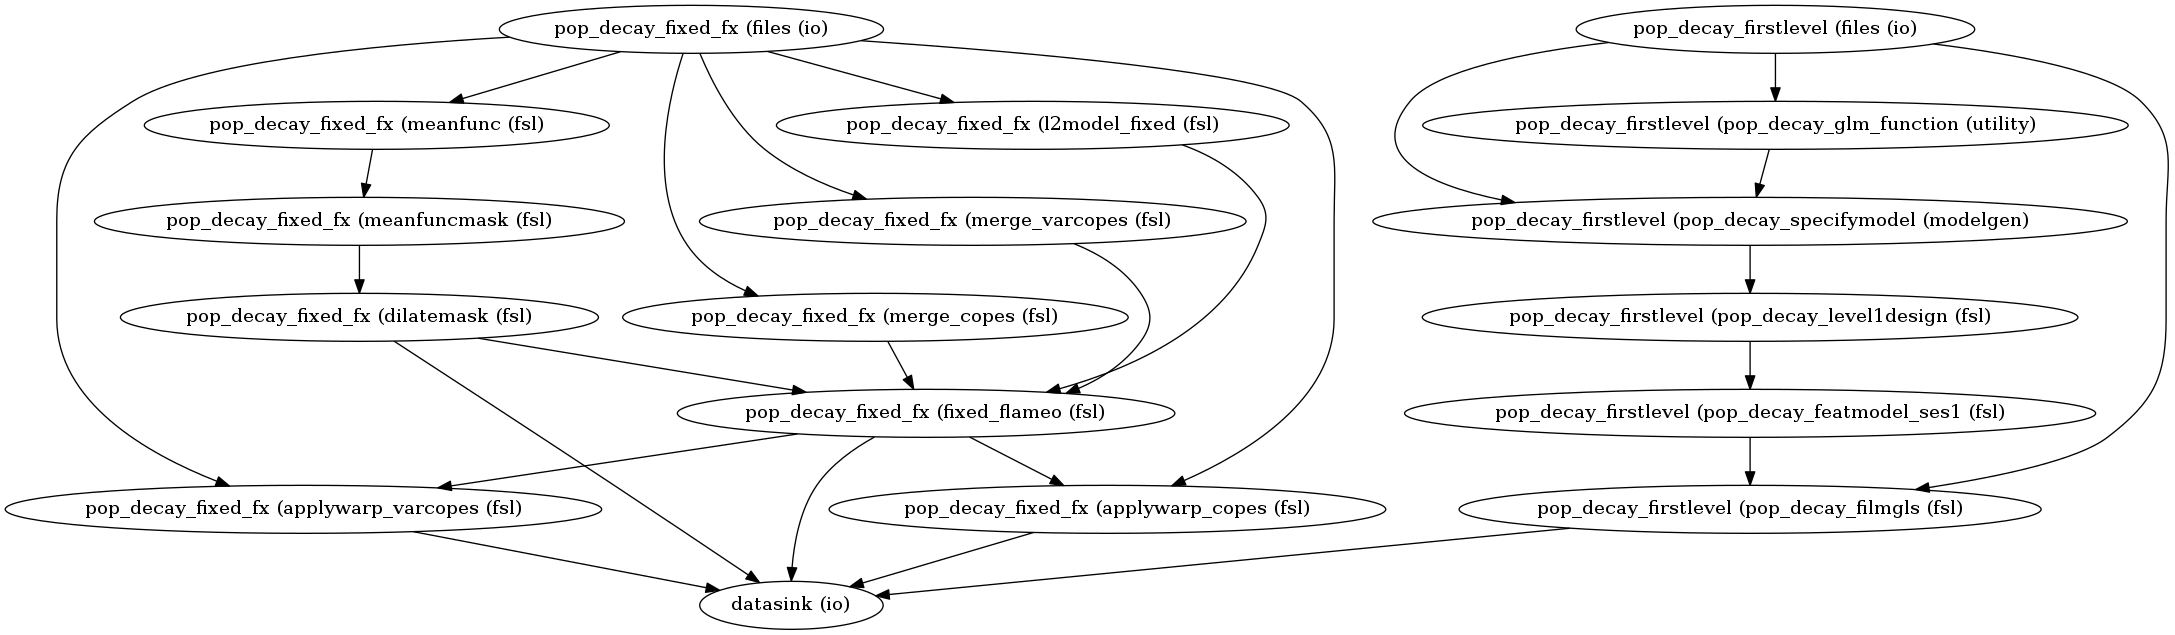

In [14]:
glm = pe.Workflow(name="glm", base_dir=working_dir)

glm.connect(firstlevel, glm_prefix+"filmgls.zstats", datasink, glm_prefix+"filmgls.@zstats")
glm.connect(firstlevel, glm_prefix+"filmgls.param_estimates", datasink, glm_prefix+"filmgls.@param_estimates")
glm.connect(firstlevel, glm_prefix+"filmgls.copes", datasink, glm_prefix+"filmgls.@copes")
glm.connect(firstlevel, glm_prefix+"filmgls.varcopes", datasink, glm_prefix+"filmgls.@varcopes")
glm.connect(firstlevel, glm_prefix+"filmgls.dof_file", datasink, glm_prefix+"filmgls.@dof_file")
glm.connect(firstlevel, glm_prefix+"filmgls.logfile", datasink, glm_prefix+"filmgls.@logfile")
glm.connect(firstlevel, glm_prefix+"filmgls.residual4d", datasink, glm_prefix+"filmgls.@residual4d")
glm.connect(firstlevel, glm_prefix+"filmgls.sigmasquareds", datasink, glm_prefix+"filmgls.@sigmasquareds")
glm.connect(firstlevel, glm_prefix+"filmgls.tstats", datasink, glm_prefix+"filmgls.@tstats")

glm.connect(fixed_fx, "dilatemask.out_file", datasink, glm_prefix + "L2_fixedfx"+".funcmask")
glm.connect(fixed_fx, "fixed_flameo.copes", datasink, glm_prefix + "_L2_fixedfx"+".copes")
glm.connect(fixed_fx, "fixed_flameo.var_copes", datasink, glm_prefix + "_L2_fixedfx"+".varcopes")
glm.connect(fixed_fx, "fixed_flameo.zstats", datasink, glm_prefix + "_L2_fixedfx"+".zstats")
glm.connect(fixed_fx, "applywarp_copes.out_file", datasink, glm_prefix + "_L2_fixedfx"+"_warped"+".copes")
glm.connect(fixed_fx, "applywarp_varcopes.out_file", datasink, glm_prefix + "_L2_fixedfx"+"_warped"+".varcopes")

glm.write_graph(simple_form=True, graph2use="exec", dotfilename="./graph_hierarchical.dot")
Image(width=768, filename="graph_hierarchical.png")

In [ ]:
glm.run(plugin='MultiProc', plugin_args={'n_procs': 4})